### Fairlearn correlation remover

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
pickle_file_path = "data/interim/train_and_test/subsets_data.pickle"

with open(pickle_file_path, 'rb') as f:
    subsets = pickle.load(f)

X_train_scaled = subsets['X_train_scaled']
X_test_scaled = subsets['X_test_scaled']
X_val_scaled = subsets['X_val_scaled']
y_train = subsets['y_train']
y_test = subsets['y_test']
y_val = subsets['y_val']

In [3]:
X_column_names = ['county_code', 'interest_rate', 'loan_to_value_ratio',
       'applicant_sex_Female', 'applicant_race-1_White', 'loan_type_FHA',
       'loan_type_VA', 'loan_type_FSA/RHS', 'debt_to_income_ratio_20%-<30%',
       'debt_to_income_ratio_30%-<36%-41%%', 'debt_to_income_ratio_36%-41%',
       'debt_to_income_ratio_41%-45%', 'debt_to_income_ratio_46%-49%',
       'debt_to_income_ratio_50%-60%', 'debt_to_income_ratio_<20%',
       'debt_to_income_ratio_>60%', 'debt_to_income_ratio_missing',
       'lien_status_Subordinate lien']

X_column_names_trans = X_column_names.copy()
X_column_names_trans.remove('applicant_race-1_White')

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_column_names)

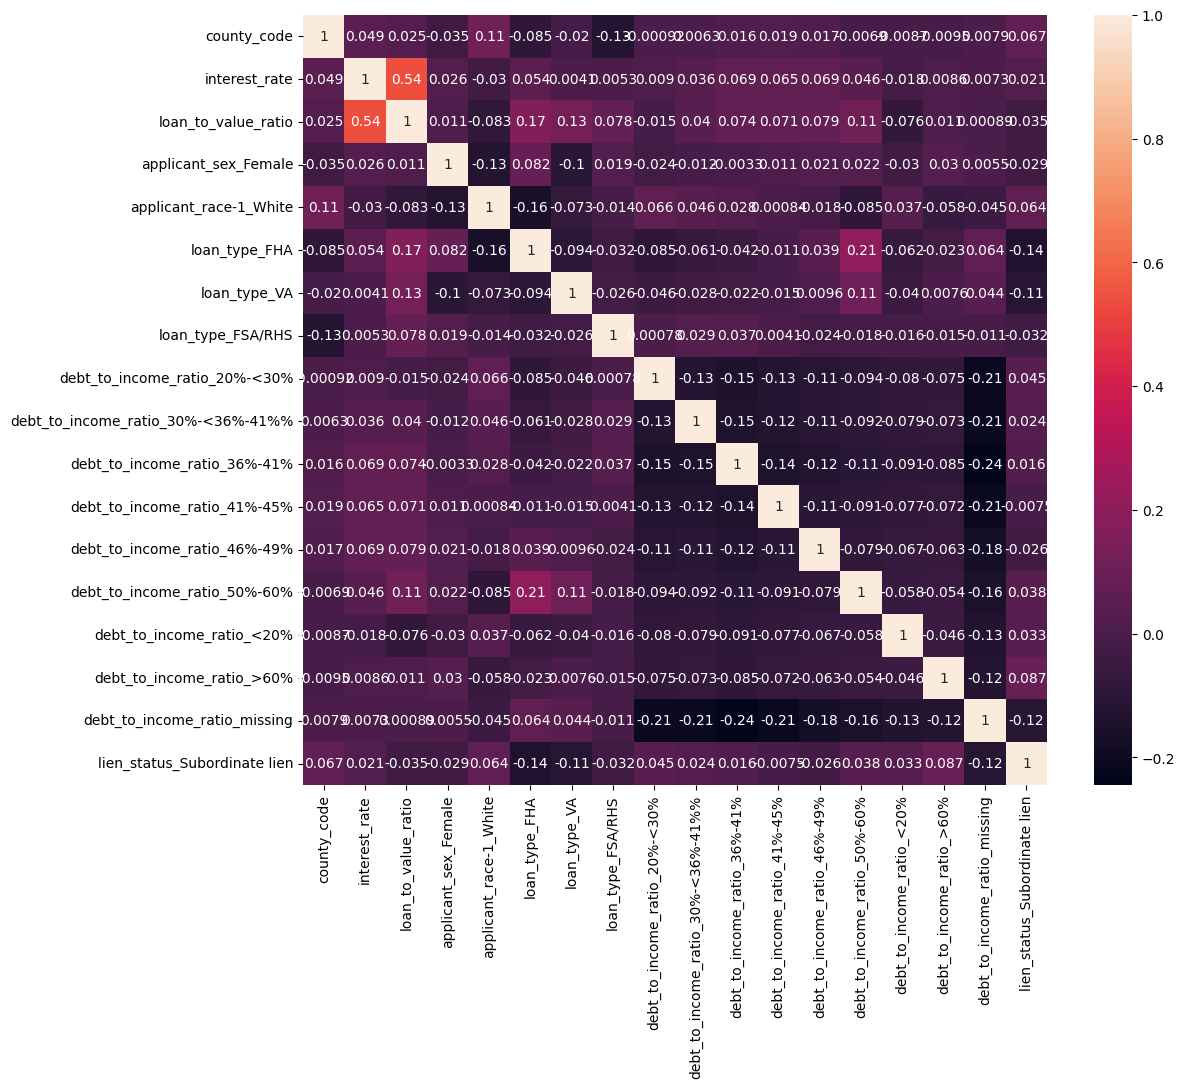

In [4]:
corr = X_train_scaled_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [5]:
from fairlearn.preprocessing import CorrelationRemover

cr = CorrelationRemover(sensitive_feature_ids=['applicant_race-1_White'])
cr.fit(X_train_scaled_df)
X_train_scaled_transform = cr.transform(X_train_scaled_df)

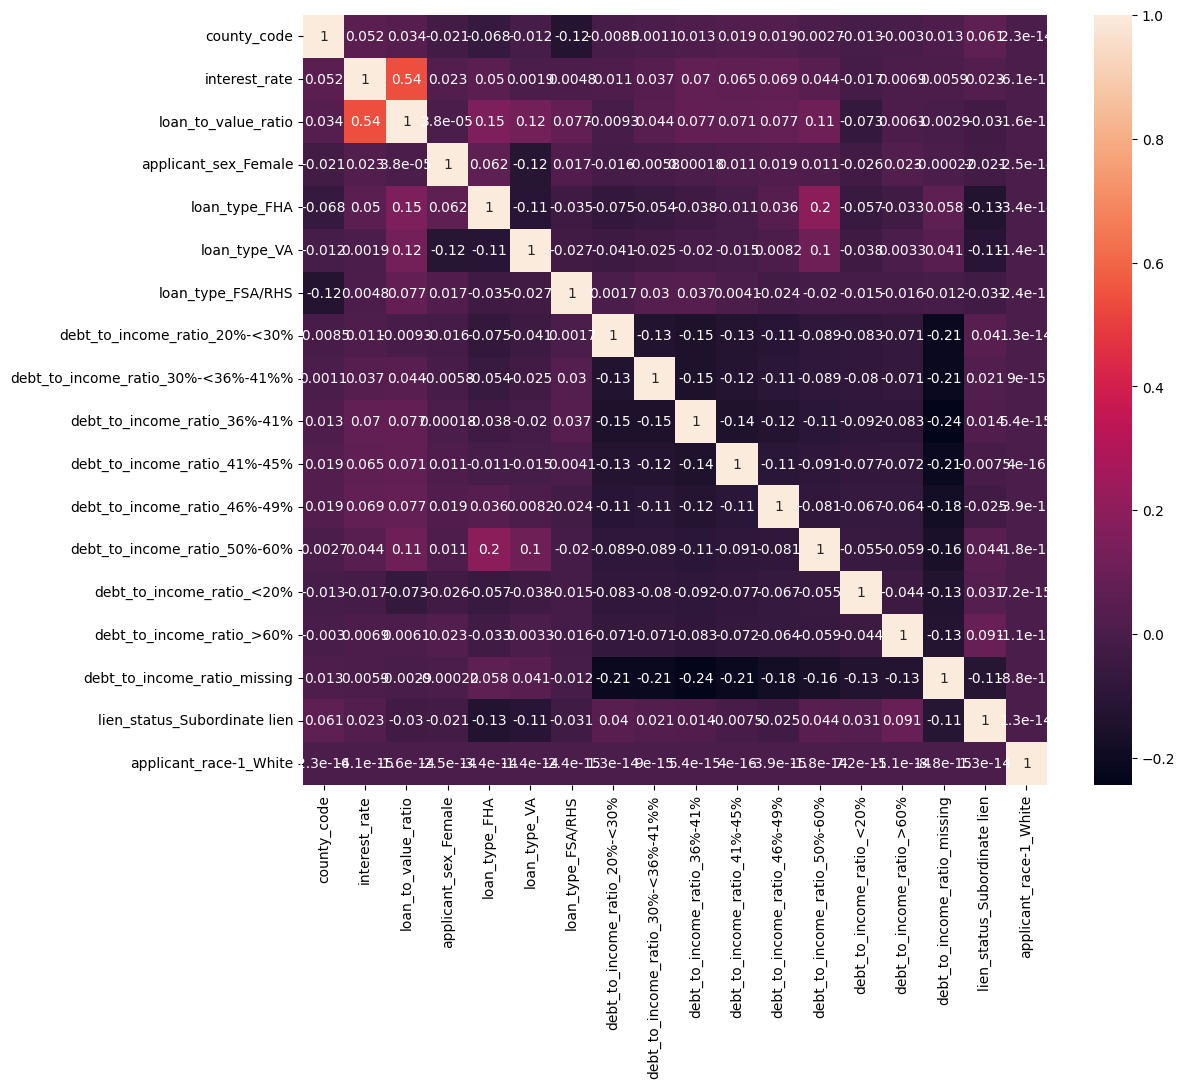

In [6]:
X_train_scaled_transform = pd.DataFrame(X_train_scaled_transform, columns=X_column_names_trans)
X_train_scaled_transform["applicant_race-1_White"] = X_train_scaled_df["applicant_race-1_White"]
corr_cr = X_train_scaled_transform.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_cr, annot=True)
plt.show()